# ProbNum 2025 Paper on Fast Gaussian Processes

https://probnum25.github.io/

## Setup

In [1]:
FULLRUN = False

In [2]:
import fastgps
import qmcpy as qp 
import torch 
import numpy as np
import scipy.stats
import time
import pandas as pd
import warnings
from matplotlib import pyplot,cm,colors
import warnings 
warnings.simplefilter("ignore")

In [3]:
CISIZE = .99
ZSTAR = scipy.stats.norm.ppf(CISIZE+(1-CISIZE)/2)
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
#pyplot.style.use("seaborn-v0_8-whitegrid")
import matplotlib.pyplot as plt
if FULLRUN:
    from tueplots.bundles import probnum2025
    plt.rcParams.update(probnum2025())
_golden = (1 + 5 ** 0.5) / 2
MW1 = 240/72
MW2 = 500/72
if not FULLRUN:
    MW1 *= 2
    MW2 *= 2
MH1 = MW1/_golden
MH2 = MW2/_golden
    

In [4]:
torch.manual_seed(11)
torch.set_default_dtype(torch.float64)

## Test functions

In [5]:
def f_grad_f(f,x):
    assert x.ndim==2
    d = x.shape[1]
    xs = [x[:,j] for j in range(d)]
    for j in range(d): xs[j].requires_grad_()
    x = torch.vstack(xs).T
    y = f(x)
    grad = [None]*d 
    for j in range(d):
        grad[j] = torch.autograd.grad(y,xs[j],grad_outputs=torch.ones_like(y),create_graph=True)[0]
    y_grad_y = torch.vstack([y]+grad).T 
    return y_grad_y.detach()
def f_curve_1d(x):
    return np.pi*x[:,0]*torch.sin(4*np.pi*x[:,0])*torch.exp(-.01/(1/2-torch.abs(x[:,0]-1/2)))
def f_G(x): # GFunction from https://www.sfu.ca/~ssurjano/gfunc.html
    assert x.ndim==2
    d = x.shape[1] 
    a = (torch.arange(1,d+1)-2)/2
    y = torch.prod((torch.abs(4*x-2)+a)/(1+a),dim=1)
    return y
def f_peaks(x): # peaks function 
    x = 6*x-3
    x1,x2 = x[:,0],x[:,1]
    t1 = 3*(1-x1)**2*torch.exp(-x1**2-(x2+1)**2)
    t2 = 10*(x1/5-x1**3-x2**5)*torch.exp(-x1**2-x2**2)
    t3 = 1/3*torch.exp(-(x1-1)**2-x2**2)
    return t1-t2-t3
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768): # https://www.sfu.ca/~ssurjano/ackley.html
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y
def f_brownian_motion(t, seed=23, numklterms=1000): # eq 6.8 https://artowen.su.domains/mc/Ch-processes.pdf
    assert t.size(1)==1
    j = torch.arange(numklterms)
    z_j = torch.from_numpy(np.random.Generator(np.random.PCG64(seed)).uniform(0,1,numklterms))
    bm = np.sqrt(2)/np.pi*(z_j*2/(2*j+1)*torch.sin((2*j+1)/2*np.pi*t)).sum(1)
    return bm
def f_branin_2d(x, a=1, b=5.1/(4*np.pi**2), c=5/np.pi, r=6, s=10, t=1/(8*np.pi)): # https://www.sfu.ca/~ssurjano/branin.html
    assert x.size(1)==2
    x1,x2 = 15*x[:,0]-5,15*x[:,1]
    y = a*(x2-b*x1**2+c*x1-r)**2+s*(1-t)*torch.cos(x1)+s
    return y
def f_camel_six_hump_2d(x): # https://www.indusmic.com/post/six-hump-camel-function
    assert x.size(1)==2
    x1,x2 = 6*x[:,0]-3,4*x[:,1]-2
    y = (4-2.1*x1**2+x1**4/3)*x1**2+x1*x2+(-4+4*x2**2)*x2**2
    return y 
def styblinski_tang(x): # https://www.sfu.ca/~ssurjano/stybtang.html
    x = 10*x-5
    y = 1/2*torch.sum(x**4-16*x**2+5*x,1)
    return y
def hartmann_6d(x):
    assert x.size(1)==6 
    alpha = torch.tensor([1.0, 1.2, 3.0, 3.2])
    A = torch.tensor([
        [10,   3,   17,   3.5, 1.7, 8],
        [0.05, 10,  17,   0.1, 8,   14],
        [3,    3.5, 1.7,  10,  17,  8],
        [17,   8,   0.05, 10,  0.1,  14]])
    P = 10**(-4)*torch.tensor([
        [1312, 1696, 5569, 124, 8283, 5886],
        [2329, 4135, 8307, 3736, 1004, 9991],
        [2348, 1451, 3522, 2883, 3047, 6650],
        [4047, 8828, 8732, 5743, 1091, 381]])
    y = -1/1.94*(2.58+torch.sum(alpha*torch.exp(-torch.einsum("ij,rij->ri",A,(x[:,None,:]-P)**2)),1))
    return y
def welch(x):
    assert x.size(1)==20
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20 = x[:,0],x[:,1],x[:,2],x[:,3],x[:,4],x[:,5],x[:,6],x[:,7],x[:,8],x[:,9],x[:,10],x[:,11],x[:,12],x[:,13],x[:,14],x[:,15],x[:,16],x[:,17],x[:,18],x[:,19]
    y = 5*x12/(1+x1)+5*(x4-x20)**2+x5+40*x19**3-5*x19+0.05*x2+0.08*x3-0.03*x6+0.03*x7-0.09*x9-0.01*x10-0.07*x11+0.25*x13**2-0.04*x14+0.06*x15-0.01*x17-0.03*x18
    return y

## Pointsets

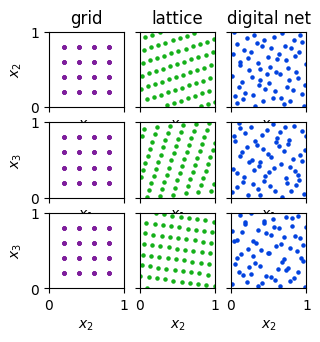

In [21]:
n = 2**6
d = 3
ngrid = np.round(n**(1/d))
assert ngrid**d==n
gridmesh = torch.meshgrid(*(torch.linspace(0,1,int(ngrid)+2)[1:-1] for j in range(d)),indexing="ij")
grid = torch.vstack([gridmesh[j].flatten() for j in range(d)]).T 
x_lattice = qp.Lattice(d,order="LINEAR",seed=7)(n)
dnb2 = qp.DigitalNetB2(d,seed=7,graycode=False,t=32)
x_dnb2 = dnb2(n)
fig,ax = pyplot.subplots(nrows=3,ncols=3,sharey=True,sharex=True,figsize=(240/72,240/72))
S = 5
for j,(name,x) in enumerate(zip(["grid","lattice","digital net"],[grid,x_lattice,x_dnb2])):
    ax[0,j].set_title(name)#,fontsize="xx-large")
    ax[0,j].scatter(x[:,0],x[:,1],s=S,color=COLORS[j])
    ax[1,j].scatter(x[:,0],x[:,2],s=S,color=COLORS[j])
    ax[2,j].scatter(x[:,1],x[:,2],s=S,color=COLORS[j])
    ax[0,j].set_xlabel(r"$x_1$")#,fontsize="xx-large")
    ax[1,j].set_xlabel(r"$x_1$")#,fontsize="xx-large")
    ax[2,j].set_xlabel(r"$x_2$")#,fontsize="xx-large")
    for i in range(3):
        ax[i,j].set_xlim([0,1]); ax[i,j].set_ylim([0,1])
        ax[i,j].set_xticks([0,1]); ax[i,j].set_yticks([0,1])
        # ax[i,j].set_xticks([0,1/4,1/2,3/4,1])
        # ax[i,j].set_xticklabels([r"$0$",r"$\frac{1}{4}$",r"$\frac{1}{2}$",r"$\frac{3}{4}$",r"$1$"])
        # ax[i,j].set_yticks([0,1/4,1/2,3/4,1])
        # ax[i,j].set_yticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
        ax[i,j].set_aspect(1)
ax[0,0].set_ylabel(r"$x_2$")#,fontsize="xx-large")
ax[1,0].set_ylabel(r"$x_3$")#,fontsize="xx-large")
ax[2,0].set_ylabel(r"$x_3$")#,fontsize="xx-large")
#fig.tight_layout()
if FULLRUN:
    fig.savefig("points.pdf")#,dpi=256,bbox_inches="tight")

## Kernel Matrix Structures

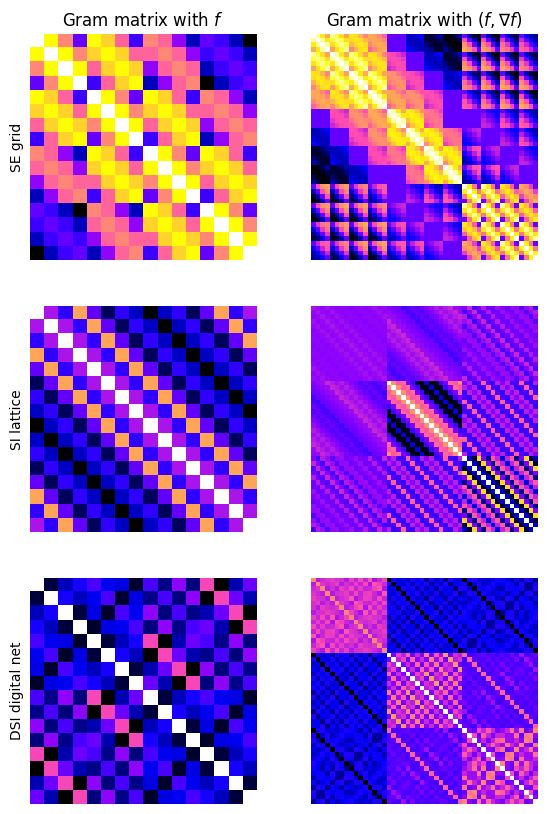

In [20]:
n = 2**4
d = 2
ngrid = np.round(n**(1/d))
assert ngrid**d==n
gridmesh = torch.meshgrid(*(torch.linspace(0,1,int(ngrid)) for j in range(d)),indexing="ij")
grid = torch.vstack([gridmesh[j].flatten() for j in range(d)]).T 
x_lattice = torch.from_numpy(qp.Lattice(d,order="LINEAR",seed=7)(n))
x_dnb2 = torch.from_numpy(qp.DigitalNetB2(d,seed=7,graycode=False,t=32)(n))
i0mesh,i1mesh = torch.meshgrid(torch.arange(n),torch.arange(n),indexing="ij")
lbetas_grad = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
sgp = fastgps.StandardGP(d)
kmat_gauss = sgp.kernel(grid[:,None,:],grid[None,:,:]).detach()
kmat_gauss_grad = torch.cat([torch.cat([sgp.kernel(grid[:,None,:],grid[None,:,:],lbetas_grad[i0],lbetas_grad[i1]) for i1 in range(len(lbetas_grad))],-1) for i0 in range(len(lbetas_grad))],-2).detach()
fgp_lat = fastgps.FastGPLattice(d,alpha=4,lengthscales=2.5e-1)
kmat_lat = fgp_lat.kernel(x_lattice[:,None,:],x_lattice[None,:,:]).detach()
kmat_lat_grad = torch.cat([torch.cat([fgp_lat.kernel(x_lattice[:,None,:],x_lattice[None,:,:],lbetas_grad[i0],lbetas_grad[i1]) for i1 in range(len(lbetas_grad))],-1) for i0 in range(len(lbetas_grad))],-2).detach()
fgp_net = fastgps.FastGPDigitalNetB2(d,alpha=4,lengthscales=2.5e-1)
kmat_net = fgp_net.kernel(x_dnb2[:,None,:],x_dnb2[None,:,:]).detach()
kmat_net_grad = torch.cat([torch.cat([fgp_net.kernel(x_dnb2[:,None,:],x_dnb2[None,:,:],lbetas_grad[i0],lbetas_grad[i1]) for i1 in range(len(lbetas_grad))],-1) for i0 in range(len(lbetas_grad))],-2).detach()
fig,ax = pyplot.subplots(nrows=3,ncols=2,figsize=(MW1,MW1/2*3))
CMAP = "gnuplot2"
for i,(name,kmat) in enumerate(zip(["SE grid","SI lattice", "DSI digital net"],[kmat_gauss,kmat_lat,kmat_net])):
    #print(name) 
    #print(kmat[:4,:4])
    #print()
    ax[i,0].imshow(kmat,cmap=CMAP)
    ax[i,0].set_ylabel(name)#,fontsize="xx-large")
for i,(name,kmat) in enumerate(zip(["SE grid","SI lattice", "DSI digital net"],[kmat_gauss_grad,kmat_lat_grad,kmat_net_grad])):
    #print(name) 
    #print(kmat[:4,:4])
    #print()
    ax[i,1].imshow(kmat,cmap=CMAP)
ax[0,0].set_title(r"Gram matrix with $f$")
ax[0,1].set_title(r"Gram matrix with $(f,\nabla f)$")
for i in range(3):
    for j in range(2):
        #ax[i,j].axis("off")
        ax[i,j].set_aspect(1)
        for spine in ["top","right","bottom","left"]:
            ax[i,j].spines[spine].set_visible(False)
        ax[i,j].set_yticks([]); ax[i,j].set_xticks([])
        #ax[i,j].get_yaxis().set_visible(False)
if FULLRUN:
    fig.savefig("gram_matrix_structures.pdf")#,dpi=256,bbox_inches="tight")

## Prior Draws

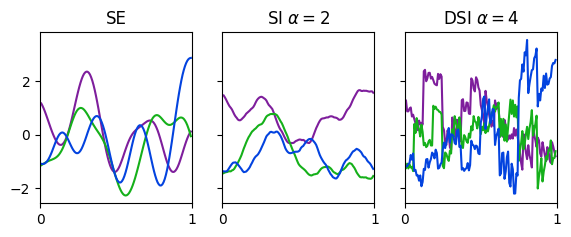

In [8]:
LW = None 
ndraws = 3
n = 127
t = 32
xticks = torch.linspace(0,1,n+2)[1:-1]
xbticks = torch.floor(xticks*2**t).to(torch.int64)
kmats = [
    ["SE", fastgps.StandardGP(1,lengthscales=1e-2,scale=2).kernel(xticks[:,None,None],xticks[None,:,None]).detach()+1e-6*torch.eye(n)],
    #[r"SI kernel $\alpha=2$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=2)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    [r"SI $\alpha=2$", fastgps.FastGPLattice(1,lengthscales=1e0,alpha=2).kernel(xticks[:,None,None],xticks[None,:,None]).detach()+1e-6*torch.eye(n)],
    #[r"SI kernel $\alpha=4$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=4)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    #[r"SI kernel $\alpha=5$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=5)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    #[r"DSI kernel $\alpha = 2$", qp.KernelDigShiftInvar(dimension=1,torchify=True,lengthscales=1e0,t=t,alpha=2)(xbticks[:,None],xbticks[:,None])+1e-6*torch.eye(n)],
    #[r"DSI kernel $\alpha = 3$", qp.KernelDigShiftInvar(dimension=1,torchify=True,lengthscales=1e0,t=t,alpha=3)(xbticks[:,None],xbticks[:,None])+1e-6*torch.eye(n)],
    [r"DSI $\alpha = 4$", fastgps.FastGPDigitalNetB2(1,lengthscales=1e0,alpha=4).kernel(xticks[:,None,None],xticks[None,:,None]).detach()+1e-6*torch.eye(n)],
]
ncols = len(kmats)
fig,ax = pyplot.subplots(nrows=1,ncols=ncols,figsize=(MW1,MW1/3),sharex=True,sharey=True)
for i,(name,kmat) in enumerate(kmats):
    L = torch.linalg.cholesky(kmat)
    r = torch.randn(ndraws,n,generator=torch.Generator().manual_seed(5))
    draws = torch.einsum("ik,rk->ri",L,r)
    for j in range(ndraws):
        ax[i].plot(xticks,draws[j],color=COLORS[j],linewidth=LW)
        ax[i].set_title(name)#,fontsize="xx-large")
        ax[i].set_xlim([0,1])
        ax[i].set_xticks([0,1])
        #ax[i].set_xticks([0,1/4,1/2,3/4,1])
        #ax[i].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
if FULLRUN:
    fig.savefig("draws.pdf")#,dpi=256,bbox_inches="tight")

## Benchmarks

In [9]:
funcs = [
    ("Ackley",1,f_ackley,False,False),
    ("Branin",2,f_branin_2d,False,True),
    ("Camel",2,f_camel_six_hump_2d,False,False),
    ("Styblinski",2,styblinski_tang,False,False),
    ("Hartmann",6,hartmann_6d,False,True),
    #("Welch",20,welch,False,False),
    ]
n = 2**10 if FULLRUN else 2**5
gps = [
    ["SE lattice", lambda d,lbetas: fastgps.StandardGP([qp.Lattice(d,seed=7) for i in range(len(lbetas))],derivatives=lbetas,num_tasks=len(lbetas))],#,requires_grad_noise=True,tfs_noise=(lambda x:torch.log10(x-1e-4),lambda x:torch.exp(x+1e-4)))],
    ["SI lattice", lambda d,lbetas: fastgps.FastGPLattice([qp.Lattice(d,seed=7) for i in range(len(lbetas))],derivatives=lbetas,alpha=2,num_tasks=len(lbetas))],
    ["DSI digital net", lambda d,lbetas: fastgps.FastGPDigitalNetB2([qp.DigitalNetB2(d,seed=7,randomize="DS") for i in range(len(lbetas))],derivatives=lbetas,alpha=4,num_tasks=len(lbetas))],
]
verbose_indent = 12
opt_steps = 15
verbose = 20#max(1,opt_steps//10)
l2rerrors_no_grad = torch.nan*torch.ones((len(funcs),len(gps)))
l2rerrors_grad = torch.nan*torch.ones((len(funcs),len(gps)))
mll_no_grad = torch.nan*torch.ones((len(funcs),len(gps)))
mll_grad = torch.nan*torch.ones((len(funcs),len(gps)))
times_no_grad = torch.nan*torch.ones((len(funcs),len(gps)))
times_grad = torch.nan*torch.ones((len(funcs),len(gps)))
datas = {}
datas_grad = {}
for i,(fname,d,f,bake,bake_grad) in enumerate(funcs):
    print(fname)
    xquery = torch.from_numpy(qp.Halton(d,seed=17).gen_samples(2**12))
    yquery = f(xquery)
    for j,(name,gp_constructor) in enumerate(gps):
        print("    %s"%name)
        print("        nograd ")
        lbetas = [torch.zeros((1,d),dtype=int)]
        gp = gp_constructor(d,lbetas)
        x_next = gp.get_x_next(n)
        assert all((x_next_i==x_next[0]).all() for x_next_i in x_next)
        f_tf = (lambda x: f(1-2*torch.abs(x-1/2))) if isinstance(gp,fastgps.FastGPLattice) and bake else f # possible Baker transform
        gp.add_y_next([f(x_next[0])])
        t0 = time.perf_counter()
        data = gp.fit(
            #iterations = opt_steps,
            verbose_indent = verbose_indent,
            verbose = verbose,
            #stop_crit_improvement_threshold = 1e-3,
            #stop_crit_wait_iterations = opt_steps,
            store_loss_hist = True,
        )
        times_no_grad[i,j] = (time.perf_counter()-t0)/data["iterations"]
        yhat = (gp.post_mean(xquery/2)+gp.post_mean(1-xquery/2))/2  if isinstance(gp,fastgps.FastGPLattice) and bake else gp.post_mean(xquery) # inverse Baker transform
        l2rerrors_no_grad[i,j] = torch.linalg.norm(yhat-yquery)/torch.linalg.norm(yquery)
        mll_no_grad[i,j] = data["loss_hist"].max()
        datas[fname+"_"+name] = data
        print("            L2 relative error = %.0e\tmll = %.0e"%(l2rerrors_no_grad[i,j],mll_no_grad[i,j]))
        print("        grad ")
        lbetas = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
        gp = gp_constructor(d,lbetas)
        x_next = gp.get_x_next(n*torch.ones(len(lbetas),dtype=int))
        #assert all((x_next_i==x_next[0]).all() for x_next_i in x_next)
        f_tf = (lambda x: f(1-2*torch.abs(x-1/2))) if isinstance(gp,fastgps.FastGPLattice) and bake_grad else f # possible Baker transform
        gp.add_y_next([f_grad_f(f_tf,x_next[i])[:,i] for i in range(len(lbetas))])
        t0 = time.perf_counter()
        data = gp.fit(
            #iterations = opt_steps,
            verbose_indent = verbose_indent,
            verbose = verbose,
            #stop_crit_improvement_threshold = 1e-3,
            #stop_crit_wait_iterations = opt_steps,
            store_loss_hist = True
        )
        times_grad[i,j] = (time.perf_counter()-t0)/data["iterations"]
        yhat = (gp.post_mean(xquery/2,task=0)+gp.post_mean(1-xquery/2,task=0))/2 if isinstance(gp,fastgps.FastGPLattice) and bake_grad else gp.post_mean(xquery,task=0) # inverse Baker transform
        l2rerrors_grad[i,j] = torch.linalg.norm(yhat-yquery)/torch.linalg.norm(yquery)
        mll_grad[i,j] = data["loss_hist"].max()
        datas_grad[fname+"_"+name] = data
        print("            L2 relative error = %.0e\t\tmll = %.0e"%(l2rerrors_grad[i,j],mll_grad[i,j]))
    print()

Ackley
    SE lattice
        nograd 
             iter of 5.0e+03 | loss       | term1      | term2     
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                    0.00e+00 | 1.80e+06   | 3.60e+06   | -2.62e+02 
                    2.00e+01 | 9.28e+01   | 1.72e+01   | 1.10e+02  
                    3.90e+01 | 8.64e+01   | 3.18e+01   | 8.21e+01  
            L2 relative error = 6e-02	mll = -9e+01
        grad 
             iter of 5.0e+03 | loss       | term1      | term2     
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                    0.00e+00 | 6.82e+09   | 1.36e+10   | -5.41e+02 
                    2.00e+01 | 5.96e+02   | 4.77e+00   | 1.07e+03  
                    2.80e+01 | 5.46e+02   | 9.66e+01   | 8.77e+02  
            L2 relative error = 3e-01		mll = -5e+02
    SI lattice
        nograd 
             iter of 5.0e+03 | loss       | term1      | term2     
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [10]:
with np.printoptions(formatter={"float":lambda x: "%.0e"%x}):
    print("l2rerrors_no_grad\n")
    print(l2rerrors_no_grad.numpy())
    print("\n\nl2rerrors_grad")
    print(l2rerrors_grad.numpy())
    print("\n\nmll_no_grad")
    print(mll_no_grad.numpy())
    print("\n\nmll_grad")
    print(mll_grad.numpy())

l2rerrors_no_grad

[[6e-02 6e-02 7e-02]
 [5e-03 1e+00 3e-01]
 [3e-01 3e-01 4e-01]
 [1e+00 1e+00 9e-01]
 [1e-01 1e-01 2e-01]]


l2rerrors_grad
[[3e-01 8e-02 2e-01]
 [2e-05 1e-01 4e-01]
 [6e-01 7e-02 3e+00]
 [8e-01 2e-01 6e+00]
 [1e-01 1e-01 1e+01]]


mll_no_grad
[[-9e+01 -6e+01 -9e+01]
 [-1e+02 -2e+02 -2e+02]
 [-1e+02 -1e+02 -1e+02]
 [-1e+02 -2e+02 -2e+02]
 [5e+00 1e+01 3e+00]]


mll_grad
[[-5e+02 -4e+02 -4e+02]
 [-3e+00 -6e+02 -7e+02]
 [-6e+02 -5e+02 -7e+02]
 [-6e+02 -6e+02 -8e+02]
 [-1e+02 -3e+02 -1e+02]]


In [11]:
fnames = [item[0] for item in funcs]
_s = r"""  \begin{tabular}{r|%s|%s}
"""%("".join("cc" for name,gp in gps),"".join("cc" for name,gp in gps))
_s += "    " + "& " + r"\multicolumn{%d}{c|}{$L_2$ relative error} & \multicolumn{%d}{c}{time per optimization step} \\"%(2*len(gps),2*len(gps))+ "\n"
_s += "   "+" & "+" & ".join(r"\multicolumn{2}{c}{%s}"%name for name,gp in gps) +" & " + " & ".join(r"\multicolumn{2}{c}{%s}"%name for name,gp in gps) + r" \\" + "\n"
_s += "    "+"benchmark & " + " & ".join(r"$f$ & $(f, \nabla f)$" for name,gp in gps) + " & " + " & ".join(r"$f$ & $(f, \nabla f)$" for name,gp in gps) + r" \\" + "\n"
_s += "    "+r"\hline" + "\n"
for i in range(len(l2rerrors_no_grad)):
    _t = ("        "+ "%s & "%fnames[i] 
    + " & ".join(r"%.1e & %.1e"%(l2rerrors_no_grad[i,j],l2rerrors_grad[i,j]) for j in range(l2rerrors_no_grad.size(1)))
    + " & "  
    + " & ".join(r"%.1e & %.1e"%(times_no_grad[i,j],times_grad[i,j]) for j in range(times_no_grad.size(1))) 
    + r" \\" + "\n")
    _t = _t.replace("e-0","e-").replace("e+0","e").replace("Styblinski","StyTang")
    _s += _t
_s += r"  \end{tabular}"
if FULLRUN:
    file = open("./benchmarks_accuracy_time.tex","w")
    file.write(_s)
    file.close()

In [12]:
fnames = [item[0] for item in funcs]
_s = r"""  \begin{tabular}{r|%s}
"""%("".join("cc" for name,gp in gps))
_s += "    " + "& " + r"\multicolumn{%d}{c}{MLL (Marginal Log Likelihood)} \\"%(2*len(gps))+ "\n"
_s += "   "+" & "+" & ".join(r"\multicolumn{2}{c}{%s}"%name for name,gp in gps) + r" \\" + "\n"
_s += "    "+"benchmark & " + " & ".join(r"$f$ & $(f, \nabla f)$" for name,gp in gps) + r" \\" + "\n"
_s += "    "+r"\hline" + "\n"
for i in range(len(mll_no_grad)):
    _t = ("        "+ "%s & "%fnames[i] 
    + " & ".join(r"%.1e & %.1e"%(mll_no_grad[i,j],mll_grad[i,j]) for j in range(mll_no_grad.size(1)))
    + r" \\" + "\n")
    _t = _t.replace("e-0","e-").replace("e+0","e").replace("Styblinski","StyTang")
    _s += _t
_s += r"  \end{tabular}"
if FULLRUN:
    file = open("./benchmarks_mll.tex","w")
    file.write(_s)
    file.close()

## 1d example

Ackley
	SE lattice
	SI lattice
	DSI digital net
smooth curve
	SE lattice
	SI lattice
	DSI digital net
Styblinski-Tang
	SE lattice
	SI lattice
	DSI digital net
G function
	SE lattice
	SI lattice
	DSI digital net
Brownian motion
	SE lattice
	SI lattice
	DSI digital net


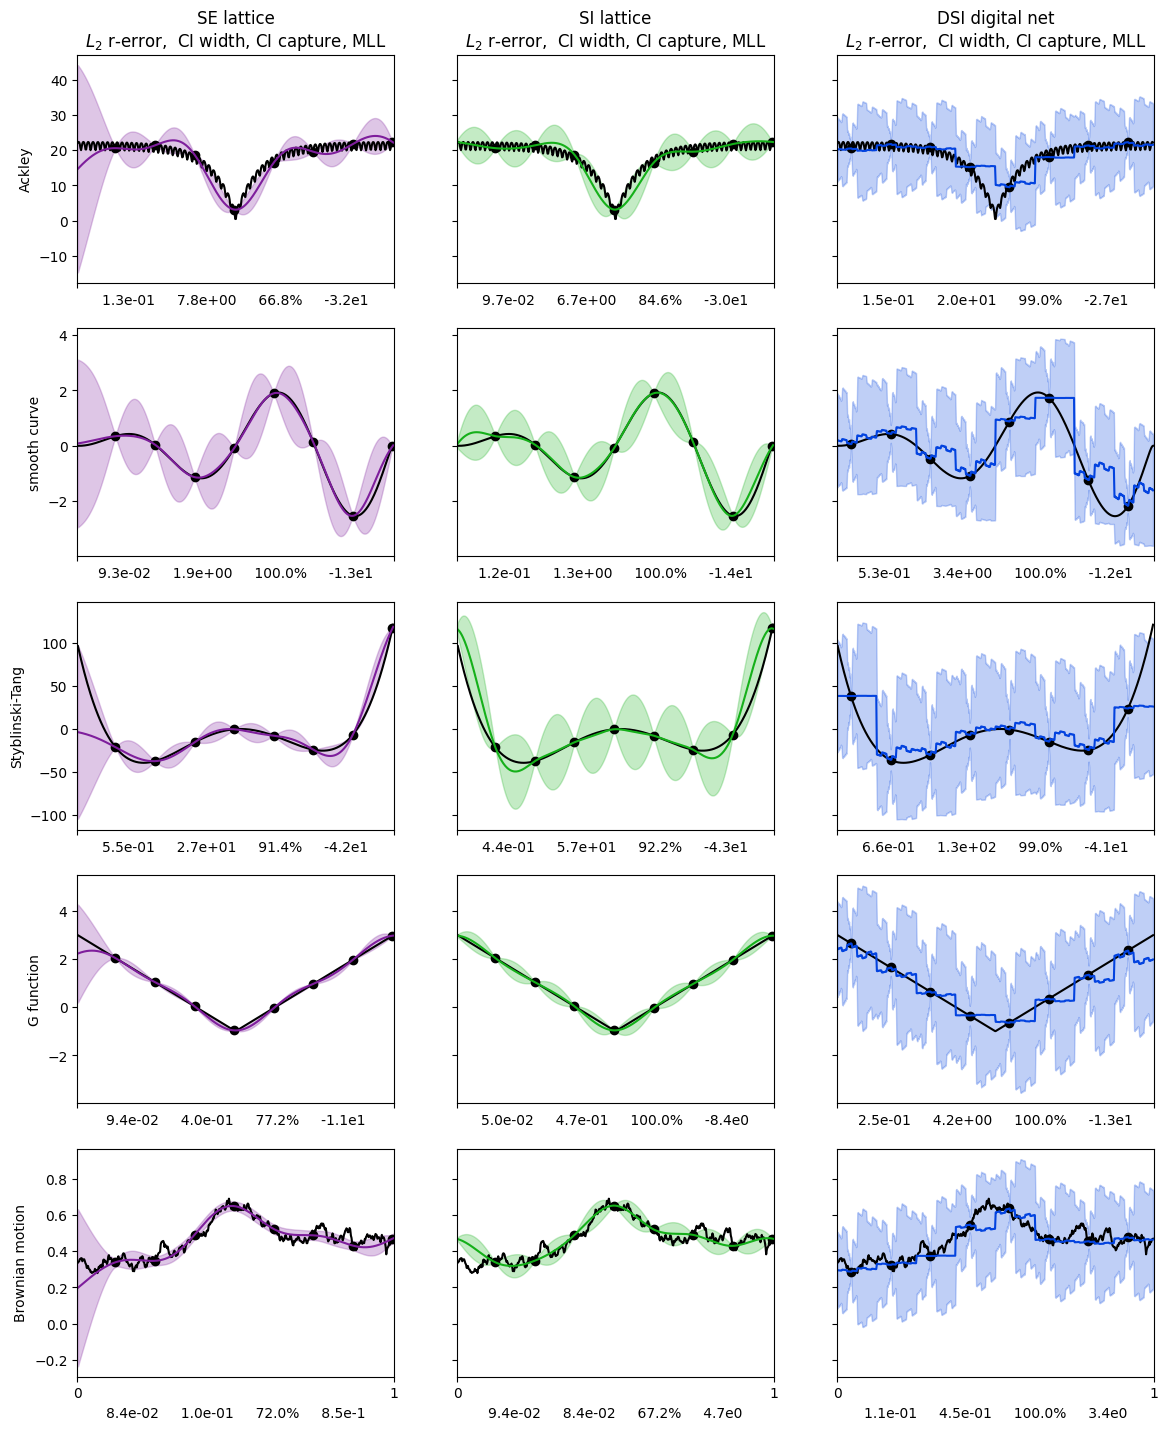

In [13]:
ACKLEY_ONLY = False 
ALPHA = 0.25 
LW = None
d = 1
n = 2**3
nticks = 500
xticks = torch.linspace(0,1,nticks+2)[1:-1]
grid = torch.linspace(0,1,n+2)[1:-1,None]
lattice = qp.Lattice(d,seed=17) 
dnb2 = qp.DigitalNetB2(d,seed=7,randomize="DS")
lbetas_no_grad = [torch.zeros((1,d),dtype=int)]
lbetas_grad = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
gps = [
    ["SE lattice", lambda: fastgps.StandardGP([lattice]*len(lbetas_no_grad),derivatives=lbetas_no_grad,num_tasks=len(lbetas_no_grad)),False],
    [r"SI lattice", lambda: fastgps.FastGPLattice([lattice]*len(lbetas_no_grad),derivatives=lbetas_no_grad,alpha=2,num_tasks=len(lbetas_no_grad)),False],
    [r"DSI digital net", lambda: fastgps.FastGPDigitalNetB2([dnb2]*len(lbetas_no_grad),derivatives=lbetas_no_grad,alpha=4,num_tasks=len(lbetas_no_grad)),False],
    # ["SE lattice", lambda: fastgps.StandardGP([lattice]*len(lbetas_grad),derivatives=lbetas_grad,num_tasks=len(lbetas_grad)),True],
    # [r"SI lattice", lambda: fastgps.FastGPLattice([lattice]*len(lbetas_grad),derivatives=lbetas_grad,alpha=2,num_tasks=len(lbetas_grad)),True],
    # [r"DSI digital net", lambda: fastgps.FastGPDigitalNetB2([dnb2]*len(lbetas_grad),derivatives=lbetas_grad,alpha=4,num_tasks=len(lbetas_grad)),True],
]
if ACKLEY_ONLY:
    funcs = [f_ackley]
    fnames = ["Ackley"]
else:
    funcs = [f_ackley,f_curve_1d,styblinski_tang,f_G,f_brownian_motion]
    fnames = ["Ackley","smooth curve","Styblinski-Tang","G function","Brownian motion"]
ncols = len(gps)
nrows = len(funcs)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(MW2,MH2/3*nrows*1.2),sharex=True,sharey="row")
ax = np.atleast_1d(ax).reshape((nrows,ncols))
for j,(f,fname) in enumerate(zip(funcs,fnames)):
    yticks = f(xticks[:,None])
    print(fname)
    for i,(name,gp_construct,grad) in enumerate(gps):
        print("\t"+name)
        gp = gp_construct()
        x_next = gp.get_x_next(n=n*torch.ones(gp.num_tasks,dtype=int))
        if not grad:
            yf = [f(x_next[0])]
        else:
            yf = [f_grad_f(f,x_next[i])[:,i] for i in range(len(x_next))]
        gp.add_y_next(yf)
        ax[j,i].plot(xticks.cpu(),yticks.cpu(),color="k",linewidth=LW)
        data = gp.fit(verbose=0,store_loss_hist=True)
        pmean = gp.post_mean(xticks[:,None])[0]
        l2rerror = torch.linalg.norm(pmean-yticks)/torch.linalg.norm(yticks)
        ax[j,i].plot(xticks.cpu(),pmean.cpu(),color=COLORS[i],linewidth=LW)
        pvar = gp.post_var(xticks[:,None])[0]
        ci_low = pmean-ZSTAR*torch.sqrt(pvar)
        ci_high = pmean+ZSTAR*torch.sqrt(pvar)
        ciwidth = torch.mean(ci_high-ci_low)
        capture = torch.mean(((yticks<ci_high)*(yticks>ci_low)).to(torch.float))
        ax[j,i].fill_between(xticks.cpu(),ci_high.cpu(),ci_low.cpu(),color=COLORS[i],alpha=ALPHA)
        ax[j,i].scatter(gp.x[0][:,0].cpu(),yf[0].cpu(),color="k",s=None)
        ax[j,i].set_xlim([0,1])
        mll_str = ("%.1e"%data["loss_hist"].max()).replace("e+0","e").replace("e+","e").replace("e-0","e-")
        spacer = "\ \ \ " if FULLRUN else "     "
        ax[j,i].set_xlabel(r"%.1e"%l2rerror+spacer+"%.1e"%ciwidth+spacer+"%.1f"%(100*capture)+("\%" if FULLRUN else "%")+spacer+mll_str)
for i,(name,gp,grad) in enumerate(gps):
    ax[0,i].set_title("%s\n%s, %s, %s, %s"%(name,r"$L_2$ r-error"," CI width","CI capture","MLL"))#,fontsize="xx-large")
    #ax[-1,i].set_xlabel(r"$x$")#,fontsize="xx-large")
    ax[-1,i].set_xlim([0,1])
    ax[-1,i].set_xticks([0,1])
    # ax[-1,i].set_xticks([0,1/4,1/2,3/4,1])
    # ax[-1,i].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
for j,(f,fname) in enumerate(zip(funcs,fnames)):
    ax[j,0].set_ylabel(fname)#,fontsize="xx-large")
#fig.tight_layout()
if FULLRUN:
    if ACKLEY_ONLY:
        fig.savefig("1d_gps_ackley.pdf")#,dpi=256,bbox_inches="tight")
    else:
        fig.savefig("1d_gps.pdf")#,dpi=256,bbox_inches="tight")

## 2d example

In [14]:
d = 2
n = 2**12 if FULLRUN else 2**8
f = f_ackley
nticks = 129 if FULLRUN else 65
x1ticks = x2ticks = torch.linspace(0,1,nticks+2)[1:-1]
x1mesh,x2mesh = torch.meshgrid(x1ticks,x2ticks,indexing="ij")
xticks = torch.vstack([x1mesh.flatten(),x2mesh.flatten()]).T 
yticks = f(xticks)
ymesh = yticks.reshape(x1mesh.shape)

In [15]:
class GridGen2d(qp.DiscreteDistribution):
    def __init__(self):
        self.mimics = 'StdUniform'
        self.low_discrepancy = False
        super().__init__(dimension=2,replications=1,seed=None,d_limit=np.inf,n_limit=np.inf)
    def gen_samples(self, n_min, n_max):
        assert n_min==0
        n = n_max 
        grid1ticks = grid2ticks = torch.linspace(0,1,int(np.sqrt(n)))
        grid1mesh,grid2mesh = torch.meshgrid(grid1ticks,grid2ticks,indexing="ij")
        grid = torch.vstack([grid1mesh.flatten(),grid2mesh.flatten()]).T
        return grid.numpy()
lbetas = [torch.zeros((1,d),dtype=int)]
#lbetas = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
gps_grad = [
    ["SE grid", fastgps.StandardGP(GridGen2d(),derivatives=lbetas)],
    ["SI lattice", fastgps.FastGPLattice(qp.Lattice(d,seed=7) ,derivatives=lbetas,alpha=2)],
    ["DSI digital net", fastgps.FastGPDigitalNetB2(qp.DigitalNetB2(d,seed=7),derivatives=lbetas,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=2", qp.FGPRDigitalNetB2(dnb2_alpha2,n,lbetas=lbetas,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=3", qp.FGPRDigitalNetB2(dnb2_alpha3,n,lbetas=lbetas,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=4", qp.FGPRDigitalNetB2(dnb2_alpha4,n,lbetas=lbetas,alpha=4)],
]
ngps = len(gps_grad)
names = [name for name,gp in gps_grad]
times = torch.zeros(len(gps_grad))
mlls = torch.zeros(len(gps_grad))
pmeanmeshes_list = [None]*ngps 
pvarmeshses_list = [None]*ngps
for i,(name,gp) in enumerate(gps_grad):
    print(name) 
    if len(lbetas)==1:
        yf = [f(gp.get_x_next(n))]
    else:
        assert len(lbetas)==(1+d)
        yf = [f_grad_f(f,x_next_i)[:,i] for x_next_i in gp.get_x_next(n=n*torch.ones(gp.num_tasks,dtype=int))]
    gp.add_y_next(yf)
    t0 = time.perf_counter()
    data = gp.fit(
        #xticks,yticks,
        #iterations=500,
        #verbose=50,
        #stop_crit_wait_iterations=500
        store_loss_hist = True
    )
    times[i] = (time.perf_counter()-t0)/data["iterations"]
    mlls[i] = data["loss_hist"].max()
    pmeanmeshes_list[i] = gp.post_mean(xticks,task=0).reshape(x1mesh.shape)[None,:,:].cpu()
    #pvarmeshses_list[i] = gp.post_var(xticks,task=0).reshape(x1mesh.shape)[None,:,:].cpu()

SE grid
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.44e+06   | 4.89e+06   | -2.26e+03 
            5.00e+00 | 1.78e+06   | 3.57e+06   | -2.20e+03 
            1.00e+01 | 5.24e+05   | 1.05e+06   | -1.81e+03 
            1.50e+01 | 3.02e+03   | 5.70e+03   | -1.28e+02 
            2.00e+01 | 5.39e+02   | 2.24e+02   | 3.83e+02  
            2.50e+01 | 5.41e+02   | 2.07e+02   | 4.04e+02  
            3.00e+01 | 5.38e+02   | 2.50e+02   | 3.56e+02  
            3.50e+01 | 5.38e+02   | 2.52e+02   | 3.53e+02  
            4.00e+01 | 5.38e+02   | 2.51e+02   | 3.54e+02  
            4.50e+01 | 5.38e+02   | 2.53e+02   | 3.52e+02  
SI lattice
     iter of 5.0e+03 | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 3.08e+03   | 6.41e+03   | -7.19e+02 
            5.00e+00 | 5.75e+02   | 8.67e+02   | -1.87e+02 
            1.00e+01 

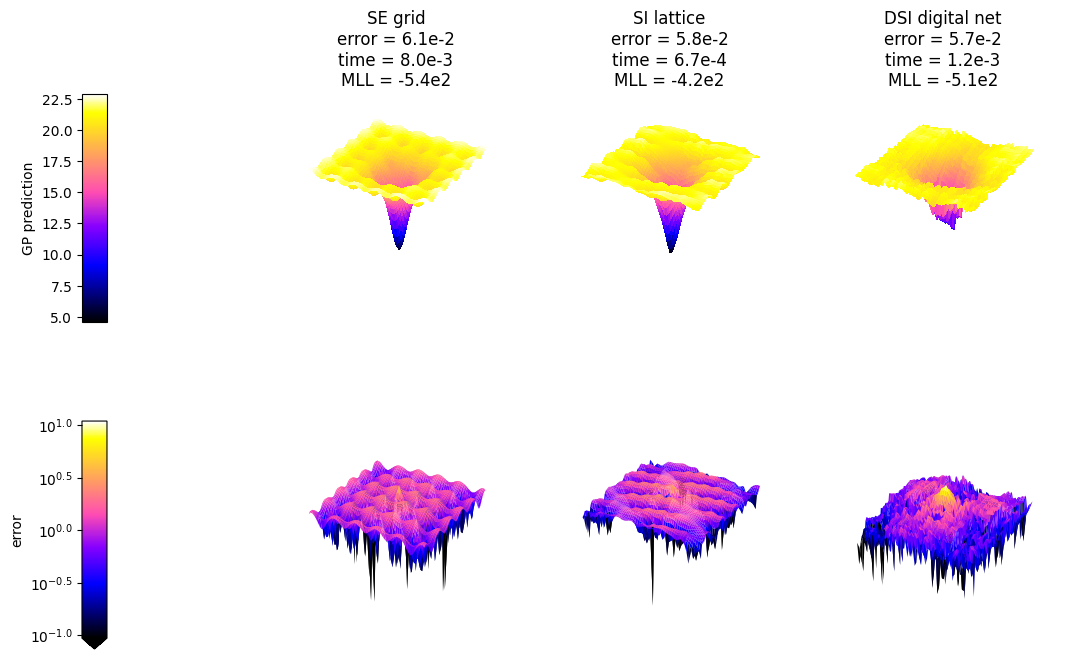

In [16]:
CMAP = cm.gnuplot2
nrows = 2
ncols = len(gps_grad)
fig = pyplot.figure(figsize=(1.5*MW1,1.75*MW1/ncols*nrows))
ax = np.array([[fig.add_subplot(nrows,ncols,ncols*i+j+1,projection="3d") for j in range(ncols)] for i in range(nrows)],dtype=object)
pmeanmeshes = torch.vstack(pmeanmeshes_list)
# pvarmeshes = torch.vstack(pvarmeshses_list)
# pvarmeshes[pvarmeshes<0] = 0.
# ci_low = pmeanmeshes-ZSTAR*torch.sqrt(pvarmeshes)
# ci_high = pmeanmeshes+ZSTAR*torch.sqrt(pvarmeshes)
# ciwidth = ci_high-ci_low
# capture = (ci_low<ymesh)*(ymesh<ci_high)
errors = torch.abs(pmeanmeshes-ymesh.cpu())
errormeshes = torch.log10(errors)
surfs = [None]*len(gps_grad)
for i,name in enumerate(names):
    pmean_max,pmean_min = pmeanmeshes.max(),pmeanmeshes.min()
    error_max,error_min = torch.quantile(errormeshes,1),torch.quantile(errormeshes,.05)
    norm_pmean = colors.Normalize(vmin=pmean_min,vmax=pmean_max)
    norm_err = colors.Normalize(vmin=error_min,vmax=error_max)
    surfs[i] = ax[0,i].plot_surface(x1mesh.cpu(),x2mesh.cpu(),pmeanmeshes[i],
        cmap=CMAP,
        vmin=pmean_min,vmax=pmean_max,
        antialiased=False,rstride=1,cstride=1,edgecolor='none')
    surfs[i] = ax[1,i].plot_surface(x1mesh.cpu(),x2mesh.cpu(),errormeshes[i],
        cmap=CMAP,
        vmin=error_min,vmax=error_max,
        #facecolors=CMAP(norm_err(errormeshes[i])),
        antialiased=True,rstride=1,cstride=1,edgecolor='none')
    l2rerror = torch.linalg.norm(errors[i])/torch.linalg.norm(ymesh)
    ax[0,i].set_title("%s\n"%name
        +(r"error = %.1e"%l2rerror).replace("e-0","e-")
        +"\n"
        +(r"time = %.1e"%times[i]).replace("e-0","e-").replace("e+0","e")
        +"\n"
        # +(r"average CI width = %.2e"%ciwidth[i].mean()).replace("e-0","e-").replace("e+0","e")
        # +"\n"
        # +(r"CI capture = %.1f"%(100*capture[i].to(torch.float).mean())).replace("e-0","e-").replace("e+0","e")+"\%"
        # +"\n"
        +(r"MLL = %.1e"%(mlls[i])).replace("e-0","e-").replace("e+0","e"))
    ax[0,i].set_zlim([pmean_min,pmean_max])
    #ax[1,i].set_zlim([errormeshes.min(),errormeshes.max()])
cax_pmean = fig.add_axes([
    ax[0,0].get_position().x0-0.2,
    ax[0,0].get_position().y0,
    .025,
    ax[0,0].get_position().y1-ax[0,0].get_position().y0,
])
cax_err = fig.add_axes([
    ax[1,0].get_position().x0-0.2,
    ax[1,0].get_position().y0,
    0.025,
    ax[1,0].get_position().y1-ax[1,0].get_position().y0,
])
cbar_pmean = fig.colorbar(cm.ScalarMappable(norm=norm_pmean,cmap=CMAP),cax_pmean,orientation="vertical",location="left",label=r"GP prediction")
cbar_err = fig.colorbar(cm.ScalarMappable(norm=norm_err,cmap=CMAP),cax_err,orientation="vertical",extend="min",location="left",label="error")
for i in range(ncols):
    for j in range(nrows):
        ax[j,i].axis("off")
        # ax[j,i].set_xlim([0,1]); ax[j,i].set_xticks([0,1])
        # ax[j,i].set_ylim([0,1]); ax[j,i].set_yticks([0,1])
        # ax[j,i].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # ax[j,i].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # ax[j,i].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # ax[j,i].xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        # ax[j,i].yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        # ax[j,i].zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        #ax[j,i].set_xlabel(r"$x_1$",fontsize="xx-large")
        #ax[j,i].set_ylabel(r"$x_2$",fontsize="xx-large")
    #ax[0,i].set_xlabel("test")
    #ax[0,i].set_zlabel(r"$f(\mathbf{x})$")#,fontsize="xx-large")
    #ax[1,i].set_zlabel(r"$|f(\mathbf{x})-f_{\mathrm{true}}(\mathbf{x})|$")#,fontsize="xx-large")
    #ax[0,i].set_zlim([pmeanmeshes.min(),pmeanmeshes.max()]); ax[i,j].set_yticks([0,1])
    #ax[1,i].zaxis._set_scale('log')
    #ax[1,i].set_zscale("log",base=10)
cbar_err.ax.set_yticklabels([r"$10^{%.1f}$"%tick for tick in cbar_err.ax.get_yticks()])
#fig.tight_layout()
if FULLRUN:
    fig.savefig("2d_gp.pdf",bbox_inches="tight")#,dpi=256)

## Speed Comparison

In [17]:
if FULLRUN:
    dvec = 2**torch.arange(0,5,dtype=int)
    nvec = 2**torch.arange(0,10,dtype=int)
else:
    dvec = torch.tensor([1,2])
    nvec = 2**torch.arange(0,7,dtype=int)
gps = [
    ["SE lattice", lambda n,lbetas: fastgps.StandardGP([qp.Lattice(d,seed=11) for i in range(len(lbetas))],derivatives=lbetas,num_tasks=len(lbetas),lengthscales=1.07e-01,scale=1.01e+01)],
    ["SI lattice", lambda n,lbetas: fastgps.FastGPLattice([qp.Lattice(d,seed=11) for i in range(len(lbetas))],derivatives=lbetas,alpha=2,num_tasks=len(lbetas),lengthscales=1e0,scale=5e8)],
    ["DSI digital net", lambda n,lbetas: fastgps.FastGPDigitalNetB2([qp.DigitalNetB2(d,seed=11,randomize='DS') for i in range(len(lbetas))],derivatives=lbetas,alpha=4,num_tasks=len(lbetas),lengthscales=2.74e-07,scale=1.53e+09)],
]
f = styblinski_tang

In [18]:
print("dvec = %s"%str(dvec.numpy()))
print("nvec = %s"%str(nvec.numpy()))
print()
times = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
times_grad = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
l2rerrors = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
l2rerrors_grad = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
for j,d in enumerate(dvec):
    x_test = torch.from_numpy(qp.Halton(d,seed=7)(2**10))
    y_test = f(x_test)
    print("d = %d"%d)
    for i,n in enumerate(nvec):
        print("    n = %d"%n)
        for k,(name,gp_constructor) in enumerate(gps):
            # no grad
            lbetas = [torch.zeros(d,dtype=int)]
            gp = gp_constructor(d,lbetas)
            #if isinstance(gp,fastgps.StandardGP) and n>=128: continue 
            x_next = gp.get_x_next(n=torch.tensor([n]))
            gp.add_y_next(f(x_next[0]))
            t0 = time.perf_counter()
            data = gp.fit(
                #iterations=250,
                verbose=25 if FULLRUN else 0,
                verbose_indent=8,
                #stop_crit_improvement_threshold = 1e-2,
                #stop_crit_wait_iterations=250,
            )
            times[k,j,i] = (time.perf_counter()-t0)/data["iterations"]
            yhat = gp.post_mean(x_test)
            l2rerrors[k,j,i] = torch.linalg.norm(y_test-yhat)/torch.linalg.norm(y_test)
            if FULLRUN: print("        %35s: \tl2 relative error = %-15.0e"%(name,l2rerrors[k,j,i]))
            if d>=16 and isinstance(gp,fastgps.StandardGP) and n>=128: continue 
            # grad
            lbetas_grad = [torch.zeros(d,dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
            gp = gp_constructor(d,lbetas_grad)
            x_next = gp.get_x_next(n*torch.ones(gp.num_tasks,dtype=int))
            gp.add_y_next([f_grad_f(f,x_next[i])[:,i] for i in range(len(x_next))])
            t0 = time.perf_counter()
            data = gp.fit(
                #iterations=250,
                verbose=25 if FULLRUN else 0,
                verbose_indent=8,
                #stop_crit_improvement_threshold = 1e-2,
                #stop_crit_wait_iterations=250,
            )
            times_grad[k,j,i] = (time.perf_counter()-t0)/data["iterations"]
            yhat = gp.post_mean(x_test,task=0)
            l2rerrors_grad[k,j,i] = torch.linalg.norm(y_test-yhat)/torch.linalg.norm(y_test)
            if FULLRUN: print("        %35s: \tl2 relative error = %-15.0e"%(name+" + grad",l2rerrors_grad[k,j,i]))
if FULLRUN:
    torch.save(nvec,"speed_accuracy_comp_data/nvec.pth")
    torch.save(l2rerrors,"speed_accuracy_comp_data/l2rerrors.pth")
    torch.save(l2rerrors_grad,"speed_accuracy_comp_data/l2rerrors_grad.pth")
    torch.save(times,"speed_accuracy_comp_data/times.pth")
    torch.save(times_grad,"speed_accuracy_comp_data/times_grad.pth")

dvec = [1 2]
nvec = [ 1  2  4  8 16 32 64]

d = 1
    n = 1
    n = 2
    n = 4
    n = 8
    n = 16
    n = 32
    n = 64
d = 2
    n = 1
    n = 2
    n = 4
    n = 8
    n = 16
    n = 32
    n = 64


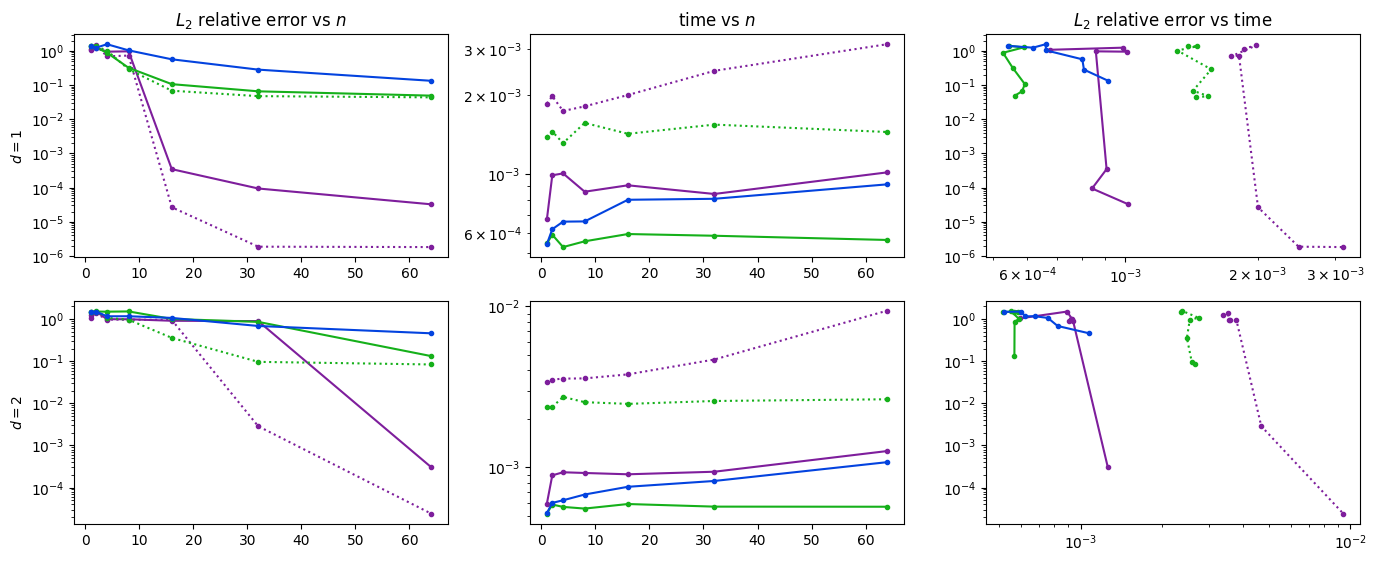

In [19]:
TRIMFIG = False 
if FULLRUN:
    nvec = torch.load("speed_accuracy_comp_data/nvec.pth")
    l2rerrors = torch.load("speed_accuracy_comp_data/l2rerrors.pth")
    l2rerrors_grad = torch.load("speed_accuracy_comp_data/l2rerrors_grad.pth")
    times = torch.load("speed_accuracy_comp_data/times.pth")
    times_grad = torch.load("speed_accuracy_comp_data/times_grad.pth")
ncols = 3
if TRIMFIG:
    js = [3]
else:
    js = [i for i in range(len(dvec))]
nrows = len(js)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(MW2,MH2/3*nrows))
ax = ax.reshape((nrows,ncols))
S = None
LW = None
MARKER = "."
LINESTYLE = "dotted"
for j,jplt in enumerate(js):
    for k in range(times.size(0)):
        label = gps[k][0]+r" $f$" if j==0 else None
        ax[j,0].plot(nvec,l2rerrors[k,jplt],marker=MARKER,color=COLORS[k],label=label,linewidth=LW,markersize=S)
        ax[j,1].plot(nvec,times[k,jplt],marker=MARKER,color=COLORS[k],label=None,linewidth=LW,markersize=S)
        ax[j,2].plot(times[k,jplt],l2rerrors[k,jplt],marker=MARKER,color=COLORS[k],label=None,linewidth=LW,markersize=S)
        if gps[k][0]=="DSI digital net": continue
        label_grad = (gps[k][0]+r" $(f,\nabla f)$") if j==0 else None
        ax[j,1].plot(nvec,times_grad[k,jplt],marker=MARKER,color=COLORS[k],label=None,linewidth=LW,markersize=S,linestyle=LINESTYLE)
        ax[j,0].plot(nvec,l2rerrors_grad[k,jplt],marker=MARKER,color=COLORS[k],label=label_grad,linewidth=LW,markersize=S,linestyle=LINESTYLE)
        ax[j,2].plot(times_grad[k,jplt],l2rerrors_grad[k,jplt],marker=MARKER,color=COLORS[k],label=None,linewidth=LW,markersize=S,linestyle=LINESTYLE)
        # ax[j,2].scatter(times[k,j],l2rerrors[k,j],marker=MARKER,color=COLORS[k],label=None,s=S*10)
        # ax[j,2].scatter(times_grad[k,j],l2rerrors_grad[k,j],marker=MARKER,color=COLORS[k],label=None,s=S*10)
for j,jplt in enumerate(js):
    for i in range(ncols):
        ax[j,i].set_yscale("log",base=10)
    #ax[j-j_offset,0].set_xscale("log",base=10)
    #ax[j-j_offset,1].set_xscale("log",base=10)
    ax[j,0].set_ylabel(r"$d=%d$"%dvec[jplt])#,fontsize="xx-large")
    ax[j,2].set_xscale("log",base=10)
ax[0,0].set_title(r"$L_2$ relative error vs $n$")#,fontsize="xx-large")
ax[0,1].set_title(r"time vs $n$")#,fontsize="xx-large")
ax[0,2].set_title(r"$L_2$ relative error vs time")#,fontsize="xx-large")
if FULLRUN:
    if TRIMFIG:
        fig.legend(frameon=False,ncol=6,bbox_to_anchor=(.5,1.1),loc="upper center") # ,fontsize="xx-large"
        fig.tight_layout()
        fig.savefig("speed_accuracy_comp_trim.pdf",dpi=256,bbox_inches="tight")
    else:
        fig.legend(frameon=False,ncol=6,bbox_to_anchor=(.5,1.03),loc="upper center") # ,fontsize="xx-large"
        fig.tight_layout()
        fig.savefig("speed_accuracy_comp.pdf",dpi=256,bbox_inches="tight")
else:
    fig.tight_layout()